In [1]:
import pandas as pd
import numpy as np
import re
import ast
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
## Uncomment if not downloaded
# nltk.download('stopwords')
# nltk.download('wordnet')

### Preparing Data

In [2]:
chat_df = pd.read_csv('./data/TakeHome_task_data.csv')
chat_df.head()

,data,label
0,"{'id': 'KG0OUA', 'data': 'Good morning', 'mess...",location
1,"{'id': 'L9DC9H', 'data': 'Location', 'message_...",whoAreYou
2,"{'id': 'ZQR6R5', 'data': 'hi', 'message_order'...",whoAreYou
3,"{'id': 'RH0M4E', 'data': 'Hi', 'message_order'...",greeting
4,"{'id': 'WLVX8I', 'data': 'Hello', 'message_ord...",greeting


In the **chat_df** Dataframe, we have a feature **data** with json objects as data with various properties. The target variable over here is **label**. The df has 2000 data samples with two columns.

In [3]:
print('The dimensions of chat_df is {}'.format(chat_df.shape))
chat_df.head()

The dimensions of chat_df is (2000, 2)


,data,label
0,"{'id': 'KG0OUA', 'data': 'Good morning', 'mess...",location
1,"{'id': 'L9DC9H', 'data': 'Location', 'message_...",whoAreYou
2,"{'id': 'ZQR6R5', 'data': 'hi', 'message_order'...",whoAreYou
3,"{'id': 'RH0M4E', 'data': 'Hi', 'message_order'...",greeting
4,"{'id': 'WLVX8I', 'data': 'Hello', 'message_ord...",greeting


**Next task is to work on the json data in the 'data' column of the df, and map the properties to various columns.**

In [4]:
data_feature_df = pd.DataFrame([ast.literal_eval(i) for i in chat_df.data.values])
data_feature_df.head()

,id,data,message_order,comments
0,KG0OUA,Good morning,2,[]
1,L9DC9H,Location,5,[]
2,ZQR6R5,hi,5,[]
3,RH0M4E,Hi,4,[]
4,WLVX8I,Hello,1,[]


[x] Drop the **data** column from the inital dataframe.

[x] Drop the **comments'** column from the **data_feature_df** as it's a constant empty value throughout.

[x] Concat both the columns.

In [5]:
chat_df = chat_df.drop('data', axis=1)
data_feature_df = data_feature_df.drop('comments', axis=1)
df = pd.concat([chat_df, data_feature_df], axis=1)
df.head()

,label,id,data,message_order
0,location,KG0OUA,Good morning,2
1,whoAreYou,L9DC9H,Location,5
2,whoAreYou,ZQR6R5,hi,5
3,greeting,RH0M4E,Hi,4
4,greeting,WLVX8I,Hello,1


**Check for missing values in the dataframe**

In [6]:
df.isnull().sum()

label            0
id               0
data             0
message_order    0
dtype: int64

**Next step is to clean the text in the 'data' feature.
These are the following options for text preprocessing:**
   
   [x] Remove all alphanumeric
    
   [x] Remove stopwords
    
   [x] Lowercase
   
   [x] Replacing all the numbers in the text with "Number" string which would help while              training the model
    
   [ ] Misspelled words - Will cover this step later in the EDA process using edit distance
    
   [x] Lemmatization
   
   [ ] Stemming - I decided to go with Lemmatization considering the use case
    
   [ ] Create a stopwords list of rare words and noise - an option later regarding the chat           domain.

In [7]:
stop_words = set(stopwords.words("english")) 
wordnet_lemmatizer = WordNetLemmatizer()

In [8]:
def standardize_text(dataframe, text_column):
    # Applying the preprocess_text function on the DataFrame column
    dataframe[text_column] = dataframe[text_column].apply(preprocess_text)
    return dataframe

def preprocess_text(string):
    alpha_pattern = r'[^a-zA-z\s]'
    string = re.sub(r"[^\w\s]", " ", str(string))   
    string = re.sub(r"\d+", "Number", string) # Replacing digits by the string 'Number'
    string = string.lower().replace(alpha_pattern, "") # Removing all the no-alpha characters
    # Creating a list of words after removing the stopwords and lemmatizing the words
    list_words = [wordnet_lemmatizer.lemmatize(item) for item in string.split(' ') if item not in stop_words]
    return " ".join(list_words)

In [9]:
cleaned_df = standardize_text(df, "data")
cleaned_df.head()

,label,id,data,message_order
0,location,KG0OUA,good morning,2
1,whoAreYou,L9DC9H,location,5
2,whoAreYou,ZQR6R5,hi,5
3,greeting,RH0M4E,hi,4
4,greeting,WLVX8I,hello,1


Defining a list of columns in an order and dropping the column **id** as it has unique values and won't being any value while training the model

In [10]:
desired_columns_order = ['message_order', 'data', 'label']
new_df = cleaned_df[desired_columns_order]
new_df.head()

,message_order,data,label
0,2,good morning,location
1,5,location,whoAreYou
2,5,hi,whoAreYou
3,4,hi,greeting
4,1,hello,greeting


The **data** feature would have some empty strings after text preprocessing. We need to drop those rows.

In [11]:
preprocessed_df = new_df[new_df['data'] != '']

In [12]:
print('The new dimensions of our preprocessed data is {}'.format(preprocessed_df.shape))

The new dimensions of our preprocessed data is (1924, 3)


In [13]:
# Saving the dataframe as a csv file 
preprocessed_df.to_csv("./data/clean_data.csv")

In [14]:
preprocessed_df.head()

,message_order,data,label
0,2,good morning,location
1,5,location,whoAreYou
2,5,hi,whoAreYou
3,4,hi,greeting
4,1,hello,greeting


### EDA & Feature Engineering

In [15]:
%matplotlib inline
from matplotlib import pyplot
from sklearn.utils import resample
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from pyxdameraulevenshtein import damerau_levenshtein_distance, normalized_damerau_levenshtein_distance

In [17]:
df = pd.read_csv('./data/clean_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,message_order,data,label
0,2,good morning,location
1,5,location,whoAreYou
2,5,hi,whoAreYou
3,4,hi,greeting
4,1,hello,greeting


Check the distribution of samples by the classes to check for Imbalanced data

In [18]:
df['label'].value_counts()

greeting                597
whoAreYou               594
notInterested           458
dontMeetRequirements    156
location                119
Name: label, dtype: int64

Creating a list of tokens from the **data** feature to get insights on the frequency and kind of the words

In [19]:
# Tokenizing the data column by using the nltk tokenizer
tokenizer = RegexpTokenizer(r'\w+')
list_of_tokens = list(df["data"].apply(tokenizer.tokenize))

print(list_of_tokens[: 10])

[['good', 'morning'], ['location'], ['hi'], ['hi'], ['hello'], ['sir'], ['k'], ['thanks'], ['hii'], ['sir', 'dnt', 'two', 'wheeler']]


**total_words** is the list of total individual tokens.
 **sentence_lengths** is the list of lengths of words in the data column, we would use this for plotting.
 **vocab** is the total number of unique tokens

In [20]:
total_words = [word for tokens in list_of_tokens for word in tokens]
sentence_lengths = [len(tokens) for tokens in list_of_tokens]
vocab = sorted(list(set(total_words)))

print("Total words is {}, with a vocabulary size of {}".format(len(total_words), len(vocab)))
print("Maximum sentence length is {}".format(max(sentence_lengths)))

Total words is 3306, with a vocabulary size of 734
Maximum sentence length is 13


Plotted the distribution of the sentence length to get an idea for futher operations to extract features from text

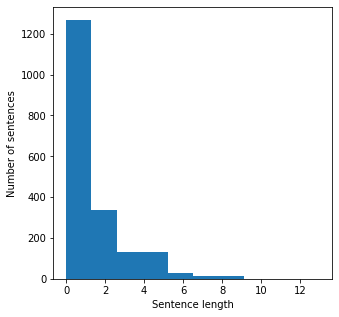

In [21]:
fig = pyplot.figure(figsize=(5, 5)) 
pyplot.xlabel('Sentence length')
pyplot.ylabel('Number of sentences')
pyplot.hist(sentence_lengths)
pyplot.show()

We can notice that there are similar amount of samples in our data by **message_order**

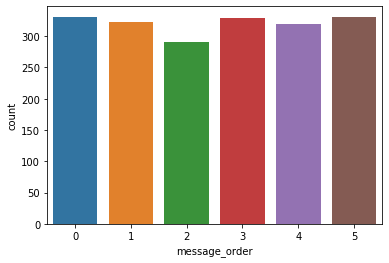

In [22]:
sns.countplot(x='message_order', data=df)

Will upsample the **location** and **dontMeetRequirements** classes using the suitable operations

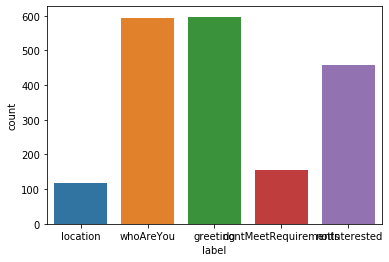

In [23]:
sns.countplot(x='label', data=df)

We can conclude from this plot that the labels are similarly distributed along the **message_order** feature respectively. Helped to break the myth I had about high coorelation of certain labels with message_order.

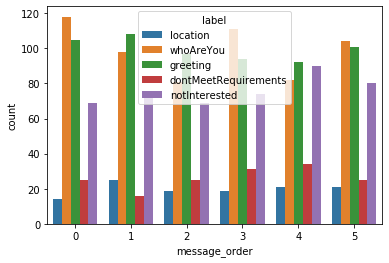

In [24]:
sns.countplot('message_order',hue='label',data=df)

Created a function to get the most frequent **n-grams** and the list of words.

In [25]:
def get_most_common_n_grams(data, n=10):
    # Using CountVectorizer and considering bi-grams to create bow data and manipulating it
    count_vec = CountVectorizer(ngram_range=(1, 2)).fit(data)
    bag_of_words = count_vec.transform(data)
    sum_of_grams = bag_of_words.sum(axis=0) # Number of occurences
    list_of_words = [word for word, _ in count_vec.vocabulary_.items()]
    n_grams_freq = [(word, sum_of_grams[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    n_grams_freq = sorted(n_grams_freq, key = lambda x: x[1], reverse=True)
    return n_grams_freq[: n], list_of_words

Here, we get an idea of the most common words in our data

In [26]:
common_n_grams, list_of_words  = get_most_common_n_grams(df['data'], 30)
top_words_df = pd.DataFrame(common_n_grams, columns=['words', 'frequency'])
print(" Total number of n-grams including uni-grams and bi-grams is {}".format(len(list_of_words)))
print(list_of_words[:10])
top_words_df.head()

 Total number of n-grams including uni-grams and bi-grams is 1655
['good', 'morning', 'good morning', 'location', 'hi', 'hello', 'sir', 'thanks', 'hii', 'dnt']


,words,frequency
0,hi,320
1,ok,308
2,sir,111
3,bike,102
4,hello,96


Over here, in the **get_dict_tokens** function I am creating a dictionary of tokens with a token as a key and the similar tokens as values. The idea behind this is to replace the similar tokens by the token key to reduce the dimensionality of the features for capture the true signal of the data. Works better and better when data increases.

In [27]:
def get_dict_tokens(list_of_tokens):
    dict_of_tokens = {}
    for token in list_of_tokens:
        if token not in dict_of_tokens:
            for key in dict_of_tokens:
                # After various iterations, I figured out normalized damerau levenshtein
                # distance works the best for this data
                if normalized_damerau_levenshtein_distance(key, token) <= 0.3:
                    dict_of_tokens[key].add(token)
                    break;
            else:
                dict_of_tokens[token] = {token}
    return dict_of_tokens

In [28]:
dict_of_tokens = get_dict_tokens(list_of_words)

print('Feature Reduction: {} vs {}'.format(len(dict_of_tokens.keys()), len(list_of_words)))
print('----')
list(dict_of_tokens.items())[: 16]

Feature Reduction: 1212 vs 1655
----


[('good', {'food', 'good'}),
 ('morning', {'morning', 'working'}),
 ('good morning', {'gd morning', 'good morning', 'good mrng', 'gud morning'}),
 ('location',
  {'location', 'location wr', 'loction', 'na location', 'ur location'}),
 ('hi', {'hi'}),
 ('hello', {'hallo', 'helli', 'hello', 'helloo', 'hellooo', 'helo'}),
 ('sir', {'sir'}),
 ('thanks', {'thank', 'thank sm', 'thanks', 'thanku', 'thaynku', 'thnaks'}),
 ('hii', {'haii', 'hii', 'hiii', 'hiio'}),
 ('dnt', {'dnt', 'dont'}),
 ('two', {'two'}),
 ('wheeler', {'wheeler'}),
 ('sir dnt', {'sir dl', 'sir dnt', 'sir want', 'sry dnt'}),
 ('dnt two', {'dnt two', 'dnt txt'}),
 ('two wheeler', {'two wheeler', 'twowheller'}),
 ('hlo', {'halo', 'hlo', 'hloo'})]

Now, we will have to replace the words in the **dict_of_tokens** dictionary values by it's key token.

In the **replace_text** function, I first check if it's a unigram or a bi-gram and replace it with the suitable string. If the length of the string is more than two, I split it and search for the ideal matches for the tokens and then join it into a single string.

In [29]:
def replace_text(string):
    if len(string) == 2 or len(string) == 1:
        matched_string = replace_one_and_bi_gram(string)
        return matched_string
    tokens = string.split(' ')
    replaced_tokens = []
    for word in tokens:
        if word in dict_of_tokens: # if present as a key, return the dict key
            replaced_tokens.append(word)
        else:
            for key_token, matches in dict_of_tokens.items(): # Searching through the dict values
                if word in matches:
                    replaced_tokens.append(key_token)
    if len(replaced_tokens) == 0: # If any of the tokens are not replaceable, return the org string
        return string
    return ' '.join(replaced_tokens)

In [30]:
def replace_one_and_bi_gram(string):
    if string in dict_of_tokens: # if present as a key, return the dict key
        return string
    else:
        for key_token, matches in dict_of_tokens.items(): # Searching through the dict values
            if string in matches:
                return key_token

In [31]:
# Applying the replace_text function on the 'data' column
df['data'] = df['data'].apply(replace_text)

In [32]:
np.save('dict_of_tokens.npy', dict_of_tokens)

In [33]:
# Dropping the null values and assigning a new DataFrame
new_df = df.dropna(how='any',axis=0)
new_df.head()

,message_order,data,label
0,2,good morning,location
1,5,location,whoAreYou
2,5,hi,whoAreYou
3,4,hi,greeting
4,1,hello,greeting


In [34]:
new_df['label'].value_counts()

greeting                589
whoAreYou               573
notInterested           446
dontMeetRequirements    154
location                116
Name: label, dtype: int64

We have to solve class imbalance problem for two labels and as well as I was going through the data, I noticed that a lot of common words are distributed just all over the classes, and those words were wrongly tagged as certain labels. So, I would drop the most common words with a high threshold from the minority labels and then upsample the minority classes. As well as I have decided to upsample the majority class a bit with least common words.

In [35]:
new_minority_df = new_df[(new_df['label'] == 'location') | (new_df['label'] == 'dontMeetRequirements')]

Using bitwise conditions here to get data according to labels

In [36]:
new_majority_df = new_df[(new_df['label'] != 'location') & (new_df['label'] != 'dontMeetRequirements')]

**top_common_words** is the array of most frequent 30 words

In [37]:
top_common_words = np.array(top_words_df['words'])
top_common_words

array(['hi', 'ok', 'sir', 'bike', 'hello', 'hii', 'hai', 'location',
       'job', 'good', 'license', 'morning', 'licence', 'hiii',
       'good morning', 'sorry', 'learning', 'thanks', 'nahi', 'kk',
       'interested', 'okay', 'mere', 'thank', 'office', 'llr', 'nhi',
       'hlo', 'address', 'pas'], dtype=object)

**minority_df** is the data without most common words with labels **locations** and **dontMeetRequirements**

In [38]:
minority_df = new_minority_df[~new_minority_df['data'].isin(top_common_words)]

**non_common_majority_df** is the data without most common words with labels other than 'locations' and 'dontMeetRequirements'

In [117]:
non_common_majority_df = new_majority_df[~new_majority_df['data'].isin(top_common_words)]

In [135]:
words = np.array(list_of_words)

In [136]:
common_majority_df = new_majority_df[new_majority_df['data'].isin(words)]

Upsampling the data 

In [137]:
new_minority_upsampled = resample(minority_df, 
                                 replace=True,     # sample with replacement
                                 n_samples=700,    # to match majority class
                                 random_state=123) 

In [138]:
new_minority_upsampled.head()

,message_order,data,label
1776,5,thanks valuable time sir,dontMeetRequirements
1082,5,vehicle,dontMeetRequirements
1495,3,क ट ह,dontMeetRequirements
1560,0,hi friend,location
1654,0,area,location


In [139]:
non_common_upsampled = resample(non_common_majority_df, 
                                 replace=True,     # sample with replacement
                                 n_samples=1000,    
                                 random_state=123) 

In [140]:
df_upsampled = pd.concat([common_majority_df, non_common_upsampled, new_minority_upsampled])
df_upsampled.head()

,message_order,data,label
1,5,location,whoAreYou
2,5,hi,whoAreYou
3,4,hi,greeting
4,1,hello,greeting
5,3,sir,whoAreYou


Reseting the index after concatenating before saving the dataframe as a csv

In [141]:
df_upsampled.reset_index(drop=True, inplace=True)

In [142]:
df_upsampled.to_csv("./data/prepared_data_post_feature_eng.csv")

### Feature Extraction & Training the Model

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import pickle
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [144]:
df = pd.read_csv('./data/prepared_data_post_feature_eng.csv')
df = df.drop(['Unnamed: 0'], axis=1)
print("The dimensions of the data is {}".format(df.shape))
df.head()

The dimensions of the data is (2999, 3)


,message_order,data,label
0,5,location,whoAreYou
1,5,hi,whoAreYou
2,4,hi,greeting
3,1,hello,greeting
4,3,sir,whoAreYou


In [145]:
df = df.dropna(how='any',axis=0)
df.reset_index(drop=True, inplace=True)

In [146]:
# Getting the data feature values for calculating tf-idf values later
text_data = np.array(df['data'])

In [147]:
tf_vec = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, ngram_range=(1,2))
tf_matrix = tf_vec.fit(text_data)
# Saving the tfidf model to use it on the test data
pickle.dump(tf_matrix, open("tfidf.pkl", "wb"))
tfi_matrix = tf_vec.transform(text_data)
tfi_matrix = tfi_matrix.toarray()

vocab = tf_vec.get_feature_names()
X_train_tfidf = pd.DataFrame(np.round(tfi_matrix, 2), columns=vocab)

In [148]:
X_train_tfidf.shape

(2999, 1222)

In [149]:
X_train_tfidf = X_train_tfidf.join(df['message_order'])

In [150]:
#  Iterabled through various Machine Learning models and concluded that
#  Decision Trees based models worked really well to learn the data.Hence, went with the
#  ensembles.'''
ensembles = []
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
num_folds = 10
seed = 7
scoring = 'accuracy'
y_train_tfidf = df['label'].tolist()

In [152]:
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    # Cross Validation with 10 kfolds to check for signs of overfitting
    cv_results = cross_val_score(model, X_train_tfidf , y_train_tfidf, cv=kfold, scoring=scoring, error_score='raise')
    print("{}: {} {}".format(name, cv_results.mean(), cv_results.std()))

RF: 0.6479464882943143 0.16717897777493995
ET: 0.6586153846153846 0.16807097527077097


Splitting the data and going with the RandomForestClassifier

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_train_tfidf, test_size=0.3)

### Evaluation

In [180]:
classifier = RandomForestClassifier(n_estimators=100)

List of labels

In [181]:
labels = list(set(y_train_tfidf))

In [182]:
%%time
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("accuracy {}".format(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred,target_names=labels))

accuracy 0.6744444444444444
                      precision    recall  f1-score   support

            greeting       0.82      0.90      0.86       125
dontMeetRequirements       0.62      0.65      0.64       246
           whoAreYou       0.91      0.93      0.92        90
            location       0.63      0.45      0.53       207
       notInterested       0.59      0.68      0.63       232

            accuracy                           0.67       900
           macro avg       0.72      0.72      0.72       900
        weighted avg       0.67      0.67      0.67       900

CPU times: user 2.27 s, sys: 196 µs, total: 2.27 s
Wall time: 2.27 s


From the calculated metrics above, we can conclude that the model is working well on certain labels with scores more around 0.85. But for other labels, we need to eyeball some of the test data and perform error analysis to check on what kind of data, the model is failing to predict. We could do certain feature engineering on that. 
I would also like to mention, we need to choose the right metric for this model to optimise as well. We need to stick to one metric suitable for the feature for eg., precision,etc and keep on optimising it.
Second, after getting the test data, we need to check if the dev test and test data (user data) are from my the same distribution. This helps in building the right model and helps with better performance. 
Last, have to come up with the satisfying metric for time execution for predicting the classes.

In [183]:
pkl_filename = "trained_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(classifier, file)

Saving the Trained Model in the pickle format and restoring it

In [184]:
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

Loading the saved tfidf model for prediction

In [185]:
tfidf_model = pickle.load(open("tfidf.pkl", 'rb'))

**predict_intent** function for predicting intent from the data(dataframe or list of dictionaries)

In [186]:
def predict_intent(chat_data):
    '''
        Function supports two kind of data and returns an array of predictions
        chat_data: (list of dictionaries and a dataframe)
        Starts with preprocessing the text data and replacing it with key tokens
        Gets the tfidf score on the saved tfidf model vocab
        Returns an array of predictions
    '''
    if isinstance(chat_data, list):
        dataframe = pd.DataFrame(chat_data)
    else:
        dataframe = chat_data.copy()
    dataframe['data'] = dataframe['data'].apply(preprocess_text)
    dataframe['data'] = dataframe['data'].apply(replace_text)
    text_data = np.array(dataframe['data'])
    tf_vec = TfidfVectorizer(ngram_range=(1,2),vocabulary = tfidf_model.vocabulary_)
    tfidf_data = tf_vec.fit_transform(text_data).toarray()
    vocab = tf_vec.get_feature_names()
    x_test_tfidf = pd.DataFrame(np.round(tfidf_data, 2), columns=vocab)
    x_test = x_test_tfidf.join(dataframe['message_order'])
    predictions = model.predict(x_test)
    return predictions

In [187]:
test_dict = [{'data': 'Hi', 'message_order': 1},
             {'data': 'Good Morning', 'message_order': 2},
             {'data': 'Kidar jaana hai', 'message_order': 4},
             {'data': 'Dont have a license', 'message_order': 3}]

In [188]:
test_df = pd.DataFrame(test_dict)
predict_intent(test_df)

array(['greeting', 'greeting', 'whoAreYou', 'dontMeetRequirements'],
      dtype='<U20')

In [189]:
predict_intent(test_dict)

array(['greeting', 'greeting', 'whoAreYou', 'dontMeetRequirements'],
      dtype='<U20')

### Future Scope

[ ] - Try Semantic Hashing for features extraction (https://arxiv.org/pdf/1810.07150.pdf)

[ ] - Work on optimizing a single metric

[ ] - Eyeball the dev test where certain labels are wrongly predicted for better error analysis

[ ] - Using synonyms for data augmentation

[ ] - Impactful Hyperparamter Tuning for the models